In [3]:
#######################################################################
# Copyright (C)                                                       #
# 2018 Sergii Bondariev (sergeybondarev@gmail.com)                    #
# 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

這次的範例主要參考[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter08/maze.py)

Chapter 13進入policy gradient，我們不再需要表格式條列的去記錄每一個state action pair所得到的action value，而是利用學習參數的方式來計算value，同時給出action。這種同時計算action與value方法稱為actor-critic，其中actor為policy，critic為value function，不過要注意的是，通常為state-value function。

下面給出範例說明

Example 13.1 Short corridor with switched actions

考慮下圖小插畫中的小走廊網格世界(small corridor gridworld)。一如往常的，每一個step的rewrad都是$-1$。在這三個nonterminal states都只有兩個actions可以選擇，右跟左。在第一、第三個states，這兩個actions都會有很常見的結果，就是左、右(第一個state的左是停在原地)，但是在第二個state是反過來的，選擇左會往右，選擇右會往左。這個問題是很難的，因為所有的states在function approximation下看起來都是一樣的。特別是，我們定義對於所有的$s$，其$\mathbf{x}(s, \text{right})=[1, 0]^T$、$\mathbf{x}(s, \text{left})=[0, 1]^T$。使用$\epsilon$-greedy的action-value methods會迫使我們在兩個策略之間做選擇：
1. 有很高的機率，高到有$1 - \epsilon/2$的機率在所有steps中選擇右
2. 相同高的機率在所有的time steps選擇左

如果$\epsilon=0.1$，那這兩個policies在start state的value就會小於$-44$與$-82$，如下圖所示：
![](https://hackmd.io/_uploads/ByRpCogvF.png)

如果有一個方法可以學習用一個特定的機率來選擇右，那這方法會明顯得到較好的結果。這最佳機率大約是$0.59$，得到的value大概是$-11.6$。

首先載入需求套件

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

然後針對範例說明來設置一個環境

In [5]:
class ShortCorridor:
    """這個範例很簡單，就4個states
    
    從最左邊的Start state開始，一路到最右邊的Goal state
    """
    def __init__(self):
        """初始化的時候先重置狀態"""
        self.reset()
        
    def reset(self):
        self.state = 0
    
    def step(self, action):
        """執行action之後的結果
        
        唯一要注意的就是在第二個state的時候，執行的action跟結果會是相反的
        其它兩個state就是很正常，
        過程中的reward都是-1，只有在最後進到目標狀態的時候才會是0
        
        action: 0: left, 1: right
        
        return reward, next_state, is_finish_flag
        """
        if self.state == 0 or self.state == 2:
            if action == 0:
                self.state = max(0, self.state - 1)
            else:
                self.state += 1
        else:
            if action == 0:
                self.state += 1
            else:
                self.state -= 1
        
        if self.state == 3:            
            reward = 0
            is_finish_flag = True
        else:
            reward = -1
            is_finish_flag = False
            
        return reward, self.state, is_finish_flag                

下面我們做個測試

In [6]:
sc = ShortCorridor()
print(sc.step(1))
print(sc.step(0))
print(sc.step(1))

(-1, 1, False)
(-1, 2, False)
(0, 3, True)


然後我們會需要一個實作REINFORCE演算法的類別，下面給出Monte-Carlo Policy Gradient的pseudocode

![](https://hackmd.io/_uploads/BJ_GRJIPY.png)

softmax在機器學習中對於多類別輸出的問題非常實用，最重要的是負值也能轉正，你總是可以輸出一個正值的機率就是

In [8]:
def softmax(x):
    """softmax function"""
    prob = np.exp(x - np.max(x))
    return prob / np.sum(prob)

In [9]:
softmax(np.array([-1.47, 1.47]))

array([0.05021127, 0.94978873])

In [10]:
class REINFORCE:
    """Monte Carlo Policy Gradient Control"""
    def __init__(self, alpha, gamma):
        """
        alpha: step size
        gamma: discount factor
        """
        # 參數初始值
        self.theta = np.array([-1.47, 1.47])
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 0.05
        
        # action，left: (0, 1), right: (1, 0)
        self.actions = [0, 1]
        self.x = np.array([[0, 1], [1, 0]])
        
        # 跟蹤記錄每個time step的reward與action
        self.track_rewards = []
        self.track_actions = []
    
    def _softmax(self, x):
        return softmax(x)
    
    def policy(self):
        """回傳當前的policy
        
        我們採用的是linear function，然後會經過softmax做轉換處理
        """
        # (2, )x(2, 2)=(2, )
        # 把參數跟action做內積
        h = np.dot(self.theta, self.x)
        # 內積之後的結果經過softmax來output probility distribution
        prob = self._softmax(h)
        
        # 為了避免policy的機率過傾，做個小判斷來調整
        min_idx = np.argmin(prob)
        
        if prob[min_idx] < self.epsilon:
            prob[:] = 1 - self.epsilon
            prob[min_idx] = self.epsilon
        
        return prob
    
    def action_select(self):
        """選擇action
        
        有了policy，我們就可以做action的選擇
        這印象中是可以有兩種做法：
         1. 一種是確定性的作法，也就是取機率最大的那一個
         2. 利用softmax回傳的機率分佈做sample
         
         範例中會利用回傳的機率分佈做sample
        """
        prob = self.policy()
        # 測試之後發現，這樣子做在初始的時候會一直選擇機率大的那個action
        # 造成學習上的困擾，所以調整成跟作者一樣的作法
        # action = np.random.choice(self.actions, p=prob)
        
        # 如果機率比選右的機率還要小，那就選右
        action = np.random.uniform() <= prob[1]
        return action
    
    def terminal(self):
        """當episode結束的時候要做的事情"""
        # 首先記錄經過幾個time steps
        T = len(self.track_rewards)
        return T

模擬一下互動結果

In [11]:
episodes = 1
for i in range(episodes):
    sr = ShortCorridor()
    rl = REINFORCE(1, 1)
    idx = 0
    while True:        
        # 選擇一個action
        _action = rl.action_select()
        # 跟環境互動一下，得到reward、next state、is finish flag
        _reward, _next_state, _is_finish_flag = sr.step(_action)
        print('time step: ', idx, 'action: ', 'left' if _action == 0 else 'right', 'reward: ', _reward, 'next_state: ', _next_state)        
        print('is_finish_flag: ', _is_finish_flag)
        # 寫入action跟reward
        rl.track_actions.append(_action)
        rl.track_rewards.append(_reward)
        idx += 1
        # 判斷是否terminal
        if _is_finish_flag:
            print('episode finish.')            
            # 取得terminal的time step
            T = len(rl.track_rewards)
            for t in range(T):              
                # 計算expected return
                G = np.sum([np.power(rl.gamma, j + 1) * k for j, k in enumerate(rl.track_rewards[t:])])
                # 判斷選擇的action是左還是右，1就是右，0就是左
                j = 1 if rl.track_actions[t] else 0    
                # 計算梯度，我們用的是softmax
                # 然後我們希望我們的output跟實際的output愈接近愈好
                # 相關推論這邊就不寫
                pmf = rl.policy()
                gradi_ln_pi = rl.x[:, j] - np.dot(rl.x, pmf)
                print('gradient: ', gradi_ln_pi, 'probs: ', pmf)    
                # 參數更新
                rl.theta = rl.theta + rl.alpha * np.power(rl.gamma, t) * G * gradi_ln_pi
            break


time step:  0 action:  left reward:  -1 next_state:  0
is_finish_flag:  False
time step:  1 action:  left reward:  -1 next_state:  0
is_finish_flag:  False
time step:  2 action:  left reward:  -1 next_state:  0
is_finish_flag:  False
time step:  3 action:  left reward:  -1 next_state:  0
is_finish_flag:  False
time step:  4 action:  left reward:  -1 next_state:  0
is_finish_flag:  False
time step:  5 action:  right reward:  -1 next_state:  1
is_finish_flag:  False
time step:  6 action:  left reward:  -1 next_state:  2
is_finish_flag:  False
time step:  7 action:  left reward:  -1 next_state:  1
is_finish_flag:  False
time step:  8 action:  left reward:  -1 next_state:  2
is_finish_flag:  False
time step:  9 action:  left reward:  -1 next_state:  1
is_finish_flag:  False
time step:  10 action:  left reward:  -1 next_state:  2
is_finish_flag:  False
time step:  11 action:  left reward:  -1 next_state:  1
is_finish_flag:  False
time step:  12 action:  left reward:  -1 next_state:  2
is_fi

time step:  192 action:  left reward:  -1 next_state:  2
is_finish_flag:  False
time step:  193 action:  left reward:  -1 next_state:  1
is_finish_flag:  False
time step:  194 action:  left reward:  -1 next_state:  2
is_finish_flag:  False
time step:  195 action:  right reward:  0 next_state:  3
is_finish_flag:  True
episode finish.
gradient:  [-0.05021127  0.05021127] probs:  [0.94978873 0.05021127]
gradient:  [-0.05  0.05] probs:  [0.95 0.05]
gradient:  [-0.05  0.05] probs:  [0.95 0.05]
gradient:  [-0.05  0.05] probs:  [0.95 0.05]
gradient:  [-0.05  0.05] probs:  [0.95 0.05]
gradient:  [ 0.95 -0.95] probs:  [0.95 0.05]
gradient:  [-0.17647386  0.17647386] probs:  [0.82352614 0.17647386]
gradient:  [-0.13086067  0.13086067] probs:  [0.86913933 0.13086067]
gradient:  [-0.10385639  0.10385639] probs:  [0.89614361 0.10385639]
gradient:  [-0.08605338  0.08605338] probs:  [0.91394662 0.08605338]
gradient:  [-0.07344673  0.07344673] probs:  [0.92655327 0.07344673]
gradient:  [-0.0640556  0.

執行結果來看應該是沒有什麼問題

把上面的學習過程弄成一個function

In [13]:
def run_rl(episodes, rl_agent):
    """學習
    episodes: episodes
    rl_agent: REINFORCE
    """
    sr = ShortCorridor()    
    rl = rl_agent()
    
    # 記錄每個episode的的total reward
    rewards = np.zeros(episodes)
    
    for i in range(episodes):
        sr.reset()        
        rl.track_rewards = []
        rl.track_actions = []
        idx = 0

        reward_sum = 0        
        while True:        
            # 選擇一個action
            _action = rl.action_select()
            # 跟環境互動一下，得到reward、next state、is finish flag
            _reward, _next_state, _is_finish_flag = sr.step(_action)
            reward_sum += _reward
#             print('time step: ', idx, 'action: ', 'left' if _action == 0 else 'right', 'reward: ', _reward, 'next_state: ', _next_state)        
#             print('is_finish_flag: ', _is_finish_flag)
            # 寫入action跟reward
            rl.track_actions.append(_action)
            rl.track_rewards.append(_reward)
            idx += 1
            # 判斷是否terminal
            if _is_finish_flag:
#                 print('episode finish.')            
                # 取得terminal的time step
                T = len(rl.track_rewards)
                for t in range(T):              
                    # 計算expected return
                    G = np.sum([np.power(rl.gamma, j + 1) * k for j, k in enumerate(rl.track_rewards[t:])])
                    # 判斷選擇的action是左還是右，1就是右，0就是左
                    j = 1 if rl.track_actions[t] else 0    
                    # 計算梯度，我們用的是softmax
                    # 然後我們希望我們的output跟實際的output愈接近愈好
                    # 相關推論這邊就不寫
                    pmf = rl.policy()
                    gradi_ln_pi = rl.x[:, j] - np.dot(rl.x, pmf)
#                     print('gradient: ', gradi_ln_pi, 'probs: ', pmf)    
                    # 參數更新
                    rl.theta += rl.alpha * np.power(rl.gamma, t) * G * gradi_ln_pi                
                break
        
        rewards[i] = reward_sum     
    return rewards

In [14]:
run_rl(10, lambda: REINFORCE(2e-4, 1))

array([ -14.,  -95., -148.,  -45.,  -45.,  -36.,  -58.,  -86.,  -21.,
        -19.])

設置一個函數來做執行

In [18]:
num_trials = 100
num_episodes = 1000

agent_generators = [lambda : REINFORCE(alpha=2e-4, gamma=1),
                    lambda : REINFORCE(alpha=2e-5, gamma=1),
                    lambda : REINFORCE(alpha=2e-3, gamma=1)]

labels = ['alpha = 2e-4',
          'alpha = 2e-5',
          'alpha = 2e-3']

rewards = np.zeros((len(agent_generators), num_trials, num_episodes))

for agent_index, agent in enumerate(agent_generators):
    for i in tqdm(range(num_trials)):
        reward = run_rl(num_episodes, agent)
        rewards[agent_index, i, :] = reward

100%|██████████| 100/100 [04:09<00:00,  2.49s/it]


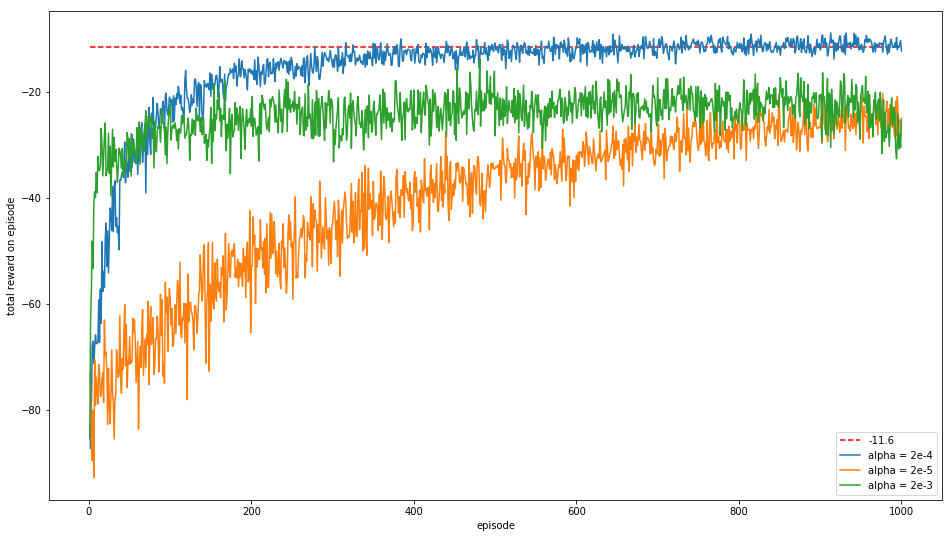

In [19]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), ls='dashed', color='red', label='-11.6')
for i, label in enumerate(labels):
    plt.plot(np.arange(num_episodes) + 1, rewards[i].mean(axis=0), label=label)
plt.ylabel('total reward on episode')
plt.xlabel('episode')
plt.legend(loc='lower right')
plt.show()